# Image Alignment

> Comprehensive image alignment methods including coarse, fine, and deep learning-based alignment techniques

In [ ]:
#| default_exp image_alignment

In [18]:
#| export
import numpy as np
import cv2
from pathlib import Path
from typing import Union, List, Tuple, Dict, Optional
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import registration, transform, feature, measure
from fastcore.all import *
import pandas as pd
from tqdm import tqdm
import warnings
import matplotlib.ticker as ticker
import math
warnings.filterwarnings('ignore')

In [15]:
#| hide
from nbdev.showdoc import *

In [16]:
#| hide
from cv_tools.core import *
from cv_tools.cv_ops import *

## Coarse Alignment Methods

These methods provide initial rough alignment between images using global features or correlation-based techniques.

In [19]:
#| export
def display_imgs(
    images, # images
    scale=2, # scale
    COLS=5, # columns
    desc=None # description
    ):
    """Display images in a grid"""
    DPI = float(mpl.rcParams['figure.dpi'])
    ROWS = math.ceil(len(images) / COLS)
    
    h, w = images[0].shape[0:2]
    fig, axs = plt.subplots(ROWS, COLS, figsize=((COLS * w * scale) / DPI, (ROWS * h * scale) / DPI))
    
    if desc is not None:
        fig.suptitle(desc, fontsize=10)
        
    axs = np.array([axs]).reshape(-1, COLS)
    for r in range(ROWS):
        for c in range(COLS):
            pos = (r * COLS) + c
            if pos < len(images):
                img = images[pos].copy()
                axs[r][c].imshow (img, cmap="gray", vmin=0, vmax=255)
                
            axs[r][c].xaxis.set_major_locator(ticker.NullLocator())
            axs[r][c].yaxis.set_major_locator(ticker.NullLocator())        
    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    return fig

In [30]:
#| export
def create_sample_image(
	size=512, # size of the image
	show=True # whether to display the image
	):
	"""Create a sample image for testing alignment methods"""
	img = np.zeros((size, size), dtype=np.uint8)
    
	# Add a main chip rectangle
	img[100:400, 100:400] = 180
    
    	# Add some "bond pads" (small rectangles)
	img[120:140, 120:180] = 220
	img[120:140, 320:380] = 220
	img[360:380, 120:180] = 220
	img[360:380, 320:380] = 220
    
	# Add a corner marker (L-shape)
	img[80:100, 80:120] = 255
	img[80:120, 80:100] = 255
    
	# Add some noise
	noise = np.random.normal(0, 5, (size, size))
	img = np.clip(img + noise, 0, 255).astype(np.uint8)
	if show:
		display_imgs([img], scale=1, COLS=1, desc="Sample Image")
    
	return img

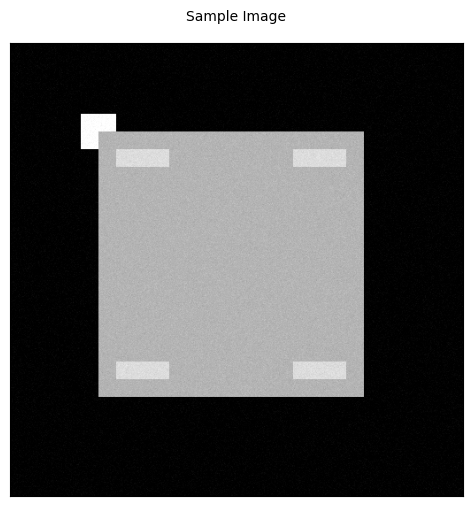

In [33]:
img = create_sample_image()

In [ ]:
#| export
def phase_correlation_alignment(
    reference_img: np.ndarray,  # Reference image (fixed)
    moving_img: np.ndarray,     # Image to be aligned (moving)
    upsample_factor: int = 100  # Subpixel precision factor
) -> Tuple[np.ndarray, Tuple[float, float]]:
    """Phase correlation-based image alignment for translation estimation"""
    
    # Convert to grayscale if needed
    if len(reference_img.shape) == 3:
        reference_img = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    if len(moving_img.shape) == 3:
        moving_img = cv2.cvtColor(moving_img, cv2.COLOR_BGR2GRAY)
    
    # Use scikit-image's phase cross correlation
    shift, error, diffphase = registration.phase_cross_correlation(
        reference_img, moving_img, upsample_factor=upsample_factor
    )
    
    # Apply the shift
    aligned_img = ndimage.shift(moving_img, shift)
    
    return aligned_img, tuple(shift)

In [ ]:
#| export
def template_matching_alignment(
    reference_img: np.ndarray,  # Reference image
    moving_img: np.ndarray,     # Image to be aligned
    template_size: int = 100,   # Size of template region
    method: str = 'cv2.TM_CCOEFF_NORMED'  # Template matching method
) -> Tuple[np.ndarray, Tuple[float, float]]:
    """Template matching-based alignment using central region as template"""
    
    # Convert to grayscale if needed
    if len(reference_img.shape) == 3:
        reference_img = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    if len(moving_img.shape) == 3:
        moving_img = cv2.cvtColor(moving_img, cv2.COLOR_BGR2GRAY)
    
    # Extract template from center of reference image
    h, w = reference_img.shape
    center_y, center_x = h // 2, w // 2
    half_size = template_size // 2
    
    template = reference_img[
        center_y - half_size:center_y + half_size,
        center_x - half_size:center_x + half_size
    ]
    
    # Perform template matching
    method_eval = eval(method)
    result = cv2.matchTemplate(moving_img, template, method_eval)
    
    # Find the best match location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # Choose location based on method
    if method in ['cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']:
        top_left = min_loc
    else:
        top_left = max_loc
    
    # Calculate shift
    expected_top_left = (center_x - half_size, center_y - half_size)
    shift_x = top_left[0] - expected_top_left[0]
    shift_y = top_left[1] - expected_top_left[1]
    
    # Apply the shift
    aligned_img = ndimage.shift(moving_img, (-shift_y, -shift_x))
    
    return aligned_img, (shift_y, shift_x)

In [ ]:
#| export
def feature_based_alignment(
    reference_img: np.ndarray,  # Reference image
    moving_img: np.ndarray,     # Image to be aligned
    detector_type: str = 'sift', # Feature detector: 'sift', 'orb', 'akaze'
    max_features: int = 5000,    # Maximum number of features
    match_threshold: float = 0.75 # Ratio test threshold for matching
) -> Tuple[np.ndarray, np.ndarray]:
    """Feature-based alignment using keypoint detection and matching"""
    
    # Convert to grayscale if needed
    if len(reference_img.shape) == 3:
        ref_gray = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    else:
        ref_gray = reference_img.copy()
        
    if len(moving_img.shape) == 3:
        mov_gray = cv2.cvtColor(moving_img, cv2.COLOR_BGR2GRAY)
    else:
        mov_gray = moving_img.copy()
    
    # Initialize detector based on type
    if detector_type.lower() == 'sift':
        detector = cv2.SIFT_create(nfeatures=max_features)
    elif detector_type.lower() == 'orb':
        detector = cv2.ORB_create(nfeatures=max_features)
    elif detector_type.lower() == 'akaze':
        detector = cv2.AKAZE_create()
    else:
        raise ValueError(f"Unknown detector type: {detector_type}")
    
    # Detect and compute features
    kp1, des1 = detector.detectAndCompute(ref_gray, None)
    kp2, des2 = detector.detectAndCompute(mov_gray, None)
    
    if des1 is None or des2 is None or len(des1) < 4 or len(des2) < 4:
        print("Not enough features detected")
        return moving_img, np.eye(3)
    
    # Match features
    if detector_type.lower() == 'orb':
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = matcher.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        good_matches = matches[:min(len(matches), 100)]
    else:
        matcher = cv2.BFMatcher()
        matches = matcher.knnMatch(des1, des2, k=2)
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < match_threshold * n.distance:
                    good_matches.append(m)
    
    if len(good_matches) < 4:
        print("Not enough good matches found")
        return moving_img, np.eye(3)
    
    # Extract matched points
    src_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Find homography
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    if homography is None:
        print("Failed to compute homography")
        return moving_img, np.eye(3)
    
    # Apply transformation
    h, w = reference_img.shape[:2]
    aligned_img = cv2.warpPerspective(moving_img, homography, (w, h))
    
    return aligned_img, homography

## Fine Alignment Methods

These methods provide precise subpixel alignment after coarse alignment.

In [ ]:
#| export
def subpixel_registration(
    reference_img: np.ndarray,  # Reference image
    moving_img: np.ndarray,     # Image to be aligned
    initial_shift: Optional[Tuple[float, float]] = None  # Initial coarse shift estimate
) -> Tuple[np.ndarray, Tuple[float, float]]:
    """Subpixel image registration using upsampled cross-correlation"""
    
    # Convert to grayscale if needed
    if len(reference_img.shape) == 3:
        reference_img = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    if len(moving_img.shape) == 3:
        moving_img = cv2.cvtColor(moving_img, cv2.COLOR_BGR2GRAY)
    
    # Apply initial shift if provided
    if initial_shift is not None:
        moving_img = ndimage.shift(moving_img, initial_shift)
    
    # High precision phase correlation
    shift, error, diffphase = registration.phase_cross_correlation(
        reference_img, moving_img, upsample_factor=1000
    )
    
    # Apply the refined shift
    total_shift = shift
    if initial_shift is not None:
        total_shift = (shift[0] + initial_shift[0], shift[1] + initial_shift[1])
    
    aligned_img = ndimage.shift(moving_img, shift)
    
    return aligned_img, tuple(total_shift)

In [ ]:
#| export
def optical_flow_alignment(
    reference_img: np.ndarray,  # Reference image
    moving_img: np.ndarray,     # Image to be aligned
    method: str = 'lucas_kanade'  # 'lucas_kanade' or 'farneback'
) -> Tuple[np.ndarray, np.ndarray]:
    """Optical flow-based fine alignment"""
    
    # Convert to grayscale if needed
    if len(reference_img.shape) == 3:
        ref_gray = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    else:
        ref_gray = reference_img.copy()
        
    if len(moving_img.shape) == 3:
        mov_gray = cv2.cvtColor(moving_img, cv2.COLOR_BGR2GRAY)
    else:
        mov_gray = moving_img.copy()
    
    if method == 'farneback':
        # Dense optical flow using Farneback method
        flow = cv2.calcOpticalFlowPyrLK(
            mov_gray, ref_gray, None, None,
            winSize=(21, 21), maxLevel=3,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
        )
        
        # Create displacement field
        h, w = ref_gray.shape
        y, x = np.mgrid[0:h, 0:w]
        
        # Apply flow to create aligned image
        map_x = (x + flow[..., 0]).astype(np.float32)
        map_y = (y + flow[..., 1]).astype(np.float32)
        
        aligned_img = cv2.remap(moving_img, map_x, map_y, cv2.INTER_LINEAR)
        
        return aligned_img, flow
    
    elif method == 'lucas_kanade':
        # Sparse optical flow using Lucas-Kanade
        # Detect corners in moving image
        corners = cv2.goodFeaturesToTrack(mov_gray, maxCorners=1000, 
                                        qualityLevel=0.01, minDistance=10)
        
        if corners is None or len(corners) < 10:
            print("Not enough corners detected")
            return moving_img, np.zeros((reference_img.shape[0], reference_img.shape[1], 2))
        
        # Track corners
        new_corners, status, error = cv2.calcOpticalFlowPyrLK(
            mov_gray, ref_gray, corners, None,
            winSize=(21, 21), maxLevel=3,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
        )
        
        # Select good points
        good_new = new_corners[status == 1]
        good_old = corners[status == 1]
        
        if len(good_new) < 4:
            print("Not enough good tracking points")
            return moving_img, np.zeros((reference_img.shape[0], reference_img.shape[1], 2))
        
        # Estimate transformation
        transform_matrix = cv2.estimateAffinePartial2D(good_old, good_new)[0]
        
        if transform_matrix is None:
            print("Failed to estimate transformation")
            return moving_img, np.zeros((reference_img.shape[0], reference_img.shape[1], 2))
        
        # Apply transformation
        h, w = reference_img.shape[:2]
        aligned_img = cv2.warpAffine(moving_img, transform_matrix, (w, h))
        
        return aligned_img, transform_matrix
    
    else:
        raise ValueError(f"Unknown optical flow method: {method}")

## Deep Learning-Based Alignment

Placeholder for future deep learning methods.

In [ ]:
#| export
def deep_learning_alignment_placeholder(
    reference_img: np.ndarray,  # Reference image
    moving_img: np.ndarray,     # Image to be aligned
    model_type: str = 'cnn'     # Future: 'cnn', 'transformer', 'optical_flow_net'
) -> Tuple[np.ndarray, Dict]:
    """Placeholder for deep learning-based alignment methods
    
    TODO: Implement CNN-based feature matching, learning-based optical flow,
    and transformer-based alignment methods.
    """
    print(f"Deep learning alignment with {model_type} - To be implemented")
    print("Future implementations could include:")
    print("- CNN-based feature extraction and matching")
    print("- Learning-based optical flow (FlowNet, PWC-Net)")
    print("- Transformer-based alignment (COTR, LoFTR)")
    print("- Unsupervised registration networks")
    
    return moving_img, {"method": model_type, "status": "not_implemented"}

## Utility Functions

In [ ]:
#| export
def calculate_alignment_metrics(
    reference_img: np.ndarray,  # Reference image
    aligned_img: np.ndarray,    # Aligned image
    original_img: np.ndarray    # Original moving image
) -> Dict[str, float]:
    """Calculate alignment quality metrics"""
    
    # Convert to grayscale if needed
    def to_gray(img):
        if len(img.shape) == 3:
            return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img
    
    ref_gray = to_gray(reference_img)
    aligned_gray = to_gray(aligned_img)
    original_gray = to_gray(original_img)
    
    # Normalize images to [0, 1]
    ref_norm = ref_gray.astype(np.float64) / 255.0
    aligned_norm = aligned_gray.astype(np.float64) / 255.0
    original_norm = original_gray.astype(np.float64) / 255.0
    
    # Calculate metrics
    metrics = {}
    
    # Mean Squared Error (lower is better)
    metrics['mse_before'] = np.mean((ref_norm - original_norm) ** 2)
    metrics['mse_after'] = np.mean((ref_norm - aligned_norm) ** 2)
    
    # Normalized Cross Correlation (higher is better)
    def normalized_cross_correlation(img1, img2):
        img1_norm = (img1 - np.mean(img1)) / np.std(img1)
        img2_norm = (img2 - np.mean(img2)) / np.std(img2)
        return np.mean(img1_norm * img2_norm)
    
    metrics['ncc_before'] = normalized_cross_correlation(ref_norm, original_norm)
    metrics['ncc_after'] = normalized_cross_correlation(ref_norm, aligned_norm)
    
    # Structural Similarity Index (higher is better)
    from skimage.metrics import structural_similarity as ssim
    metrics['ssim_before'] = ssim(ref_norm, original_norm)
    metrics['ssim_after'] = ssim(ref_norm, aligned_norm)
    
    # Improvement ratios
    metrics['mse_improvement'] = (metrics['mse_before'] - metrics['mse_after']) / metrics['mse_before']
    metrics['ncc_improvement'] = (metrics['ncc_after'] - metrics['ncc_before']) / abs(metrics['ncc_before'])
    metrics['ssim_improvement'] = (metrics['ssim_after'] - metrics['ssim_before']) / metrics['ssim_before']
    
    return metrics

In [ ]:
#| export
def multi_method_alignment(
    reference_img: np.ndarray,  # Reference image
    moving_img: np.ndarray,     # Image to be aligned
    methods: List[str] = ['phase_correlation', 'feature_based'],  # Methods to try
    return_best: bool = True     # Return best result based on metrics
) -> Dict:
    """Try multiple alignment methods and return results"""
    
    results = {}
    
    for method in methods:
        try:
            if method == 'phase_correlation':
                aligned, transform = phase_correlation_alignment(reference_img, moving_img)
            elif method == 'template_matching':
                aligned, transform = template_matching_alignment(reference_img, moving_img)
            elif method == 'feature_based':
                aligned, transform = feature_based_alignment(reference_img, moving_img)
            elif method == 'subpixel':
                aligned, transform = subpixel_registration(reference_img, moving_img)
            elif method == 'optical_flow':
                aligned, transform = optical_flow_alignment(reference_img, moving_img)
            else:
                print(f"Unknown method: {method}")
                continue
            
            # Calculate metrics
            metrics = calculate_alignment_metrics(reference_img, aligned, moving_img)
            
            results[method] = {
                'aligned_image': aligned,
                'transform': transform,
                'metrics': metrics
            }
            
        except Exception as e:
            print(f"Method {method} failed: {str(e)}")
            continue
    
    if return_best and results:
        # Find best method based on SSIM improvement
        best_method = max(results.keys(), 
                         key=lambda m: results[m]['metrics']['ssim_after'])
        results['best_method'] = best_method
        results['best_result'] = results[best_method]
    
    return results

## Testing and Examples

Example usage and testing with the microscopy dataset.

In [ ]:
#| hide
# Example usage - uncomment to test
# img1, _ = get_single_sample(INDEX=0, type='numpy')
# img2, _ = get_single_sample(INDEX=1, type='numpy')

# # Test phase correlation alignment
# aligned, shift = phase_correlation_alignment(img1, img2)
# print(f"Detected shift: {shift}")

# # Test multiple methods
# results = multi_method_alignment(img1, img2, 
#                                 methods=['phase_correlation', 'template_matching', 'feature_based'])
# print(f"Best method: {results.get('best_method')}")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()